# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'long_short_term_memory_regression'

In [6]:
regression_data = pd.read_csv(data_dir+'regression_data.csv', index_col=[0])

# LSTM (Regression)

## Functions

In [7]:
def build_model_LSTM(input_shape, hid_layer_nums = 1, units=100):
    # LSTM model
    model = Sequential()

    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=units, 
                   kernel_regularizer=keras.regularizers.l2(0.001), 
                   return_sequences=True, 
                   kernel_initializer='random_normal',
                   bias_initializer='zeros',
                   input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Hidden LSTM layers
    for hid_layer_num in range(hid_layer_nums-1):
        model.add(LSTM(units=units, 
                       kernel_regularizer=keras.regularizers.l2(0.001), 
                       return_sequences=True))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    # Last LSTM layer
    model.add(LSTM(units=units, 
                   kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # The output layer
    model.add(Dense(units=1, activation='sigmoid'))

    return model

## Implementation

Sort the dataset so we can drop the date column

In [8]:
regression_data = regression_data.sort_values(by=['date', 'team', 'department']).reset_index(drop=True)

In [9]:
dep_var = ['targeted_productivity']

In [10]:
regression_data

,date,department,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,...,targeted_productivity_rmean_1_1,targeted_productivity_rmean_2_1,targeted_productivity_rmean_1_2,targeted_productivity_rmean_2_2,actual_productivity_lag_2,actual_productivity_lag_4,actual_productivity_rmean_2_1,actual_productivity_rmean_4_1,actual_productivity_rmean_2_2,actual_productivity_rmean_4_2
0,2015-01-01,finishing,1,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2015-01-01,sweing,1,0.75,28.08,681.0,6900,45,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2015-01-01,finishing,2,0.75,3.94,0.0,960,0,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2015-01-01,sweing,2,0.75,19.88,733.0,6000,34,0.0,0,...,0.75,0.00,0.375,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2015-01-01,sweing,3,0.75,28.08,795.0,6900,45,0.0,0,...,0.00,0.00,0.000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,sweing,10,0.75,21.81,1674.0,6000,34,0.0,0,...,0.70,0.75,0.725,0.725,0.7505,0.7000,0.7505,0.7000,0.6140,0.5710
1193,2015-03-11,finishing,11,0.80,2.90,0.0,2400,0,0.0,0,...,0.80,0.80,0.800,0.800,0.8000,0.9604,0.8000,0.9604,0.8000,0.8580
1194,2015-03-11,sweing,11,0.80,11.41,560.0,3420,50,0.0,0,...,0.80,0.80,0.800,0.800,0.7583,0.8000,0.7583,0.8000,0.7793,0.8800
1195,2015-03-11,finishing,12,0.80,4.60,0.0,2160,0,0.0,0,...,0.80,0.80,0.800,0.800,0.9200,0.9030,0.9200,0.9030,0.8604,0.8516


In [30]:
categorical = np.array(['department', 'team'])

In [31]:
continuous = np.setdiff1d(np.setdiff1d(regression_data.columns,categorical), dep_var)

In [32]:
continuous = continuous[continuous != 'date']

In [33]:
X = regression_data.loc[:,np.union1d(categorical, continuous)]

In [34]:
y = regression_data.loc[:,dep_var]*100

In [16]:
columns = ['task', 'model', 'split', 'optimizer', 'hidden_layers_no', 'units', 'valid_mean_value', 'predicted_mean_value', 'percentage_difference', 'valid_rsq', 'valid_mae', 'valid_mse', 'valid_rmse', 'train_mae', 'train_mse', 'train_rmse']
long_short_term_memory_regression_results_df = pd.DataFrame(columns=columns)
df_rows = 0

Now we need to prepare our data and the cross-validation process so that we can start training. As we are dealing with time-series we need to split the data appropriately. We will use 20% of the data for testing.

In [35]:
test_idx = int((0.2*len(X)))

In [53]:
X_train, X_test, y_train, y_test = X.iloc[:len(X)- test_idx, :], X.iloc[len(X)- test_idx:, :], y.iloc[:len(y)- test_idx, :], y.iloc[len(y)- test_idx:, :]

In [54]:
adam = keras.optimizers.Adam(learning_rate=0.01)
optimizers = {'adam': adam}

In [234]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
print('Starting training')
# assign the tuned parameters
split = 0
num_of_hidden_layers = [3, 4, 5, 6, 7, 8, 9]
num_of_units = [16, 32, 64, 128, 256, 384] 
    
tscv = TimeSeriesSplit(n_splits=5)
for train_index, valid_index in tscv.split(X_train):
    # Data Split
    split += 1
    X_train_curr_split = X_train.iloc[train_index]
    X_valid_curr_split = X_train.iloc[valid_index]
    y_train_curr_split = y_train.iloc[train_index].values
    y_valid_curr_split = y_train.iloc[valid_index].values
    # Avoiding data leakage for input values
    
    # Encode the data
    enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
    X_train_curr_split.loc[:, categorical] = enc.fit_transform(X_train_curr_split[categorical])
    X_valid_curr_split.loc[:, categorical] = enc.transform(X_valid_curr_split[categorical])

    # Scale the data        
    scaler_x = preprocessing.StandardScaler()
    X_train_curr_split = scaler_x.fit_transform(X_train_curr_split)
    X_valid_curr_split = scaler_x.transform(X_valid_curr_split)
    
    scaler_y = preprocessing.StandardScaler()
    y_train_curr_split_transformed = scaler_y.fit_transform(y_train_curr_split)
    y_valid_curr_split_transformed = scaler_y.transform(y_valid_curr_split)
    
    # Reshape the data
    X_train_curr_split_transformed = X_train_curr_split.reshape(X_train_curr_split.shape[0], 1, X_train_curr_split.shape[1])
    X_valid_curr_split_transformed = X_valid_curr_split.reshape(X_valid_curr_split.shape[0], 1, X_valid_curr_split.shape[1])



    input_shape = (X_train_curr_split_transformed.shape[1], X_train_curr_split_transformed.shape[2])
    
    for hidden_layers in num_of_hidden_layers:
        for units in num_of_units:
            model = build_model_LSTM(input_shape, hid_layer_nums = hidden_layers, units=units)
            model.compile(optimizer=optimizers['adam'], loss=keras.losses.MeanAbsoluteError(), metrics=["mse", "mae"])

            # train the model
            model.fit(X_train_curr_split_transformed, y_train_curr_split_transformed, epochs=40, batch_size=16, verbose=1,
                      validation_data=(X_valid_curr_split_transformed, y_valid_curr_split_transformed)) 
            # make predictions       
            train_predictions = model.predict(X_train_curr_split_transformed)
            train_predictions = scaler_y.inverse_transform(train_predictions)
            
            valid_predictions = model.predict(X_valid_curr_split_transformed)
            valid_predictions = scaler_y.inverse_transform(valid_predictions)
            # Obtain metric scores
            valid_mae = mean_absolute_error(y_valid_curr_split, valid_predictions)
            train_mae = mean_absolute_error(y_train_curr_split, train_predictions)
            valid_mse = mean_squared_error(y_valid_curr_split, valid_predictions)
            train_mse = mean_squared_error(y_train_curr_split, train_predictions)
            valid_rmse = mean_squared_error(y_valid_curr_split, valid_predictions, squared=False)
            train_rmse = mean_squared_error(y_train_curr_split, train_predictions, squared=False)
            valid_rsq = r2_score(y_valid_curr_split, valid_predictions)
            valid_mean_value = y_valid_curr_split.mean()
            predicted_mean_value = valid_predictions.mean()
            
            percetange_difference = ((y_valid_curr_split - valid_predictions)/(y_valid_curr_split)).mean()
            long_short_term_memory_regression_results_df.loc[df_rows] = ['regression',
                                                                         'LSTM',
                                                                         split,
                                                                         'adam',
                                                                         hidden_layers,
                                                                         units,
                                                                         valid_mean_value,
                                                                         predicted_mean_value,
                                                                         percetange_difference,
                                                                         valid_rsq,
                                                                         valid_mae,
                                                                         valid_mse,
                                                                         valid_rmse,
                                                                         train_mae,
                                                                         train_mse,
                                                                         train_rmse
                                                                         ]
            # increment the rows variable
            df_rows +=1
print('Done training')     

Starting training
Epoch 1/40
11/11 [==============================] - 19s 934ms/step - loss: 1.5626 - mse: 1.1657 - mae: 0.6283 - val_loss: 3.0321 - val_mse: 4.3431 - val_mae: 1.2362
Epoch 2/40
11/11 [==============================] - 8s 750ms/step - loss: 2.9194 - mse: 1.0312 - mae: 0.5854 - val_loss: 4.0991 - val_mse: 4.2907 - val_mae: 1.2507
Epoch 3/40
11/11 [==============================] - 8s 734ms/step - loss: 3.5730 - mse: 1.0151 - mae: 0.6026 - val_loss: 4.2310 - val_mse: 4.5855 - val_mae: 1.1809
Epoch 4/40
11/11 [==============================] - 9s 815ms/step - loss: 3.5897 - mse: 1.0726 - mae: 0.5789 - val_loss: 4.1789 - val_mse: 5.3877 - val_mae: 1.2539
Epoch 5/40
11/11 [==============================] - 8s 738ms/step - loss: 3.4030 - mse: 1.1373 - mae: 0.5645 - val_loss: 3.8001 - val_mse: 4.9797 - val_mae: 1.1060
Epoch 6/40
11/11 [==============================] - 8s 720ms/step - loss: 3.1180 - mse: 1.1202 - mae: 0.5487 - val_loss: 3.6416 - val_mse: 5.3677 - val_mae: 1.24

KeyboardInterrupt: 

## Functions

In [111]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [11]:
long_short_term_memory_regression_results_df

,task,model,split,optimizer,hidden_layers_no,units,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse,train_mae,train_mse,train_rmse
0,regression,LSTM,1,adam,3,16,73.364780,79.980190,-0.135447,-0.314444,6.642293,182.904834,13.524231,2.889852,44.660166,6.682826
1,regression,LSTM,1,adam,3,32,73.364780,79.699295,-0.130691,-0.245398,6.444775,173.297058,13.164234,2.834895,41.785381,6.464161
2,regression,LSTM,1,adam,3,64,73.364780,79.460530,-0.126775,-0.196228,6.328182,166.455099,12.901748,2.776346,39.152106,6.257164
3,regression,LSTM,1,adam,3,128,73.364780,79.488106,-0.127068,-0.194859,6.344475,166.264565,12.894362,2.744141,36.500402,6.041556
4,regression,LSTM,1,adam,3,256,73.364780,77.116570,-0.094794,-0.101156,7.705173,153.225833,12.378442,3.927133,36.471070,6.039128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,regression,LSTM,5,adam,9,32,73.144654,78.654110,-0.094830,-0.460410,6.611423,98.533311,9.926395,6.791200,132.535814,11.512420
206,regression,LSTM,5,adam,9,64,73.144654,75.074295,-0.043201,0.079909,4.795356,62.078196,7.878972,5.451628,102.530340,10.125727
207,regression,LSTM,5,adam,9,128,73.144654,74.954130,-0.042546,0.007480,5.237413,66.964964,8.183212,5.442037,101.286314,10.064110
208,regression,LSTM,5,adam,9,256,73.144654,73.231540,-0.019306,-0.000112,5.929236,67.477190,8.214450,7.393611,105.757403,10.283842


In [113]:
long_short_term_memory_regression_results_df.to_csv(results_dir + 'long_short_term_memory_regression_results_df.csv')

Aggregate the values so that we average the results for each split

In [115]:
grouped_long_short_term_memory_regression_results_df = group_seeded_data(long_short_term_memory_regression_results_df, 
                                                                         ['optimizer', 'hidden_layers_no','units'],
                                                                         ['split']
                                                                        )

In [116]:
grouped_long_short_term_memory_regression_results_df

,optimizer,hidden_layers_no,units,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse,train_mae,train_mse,train_rmse
0,adam,3,16,72.41761,77.088760,-0.105013,-0.083443,5.856336,117.167086,10.669617,4.067463,76.958173,8.711704
1,adam,3,32,72.41761,76.952003,-0.103360,-0.090160,5.916133,117.673322,10.706694,4.021460,76.211371,8.659324
2,adam,3,64,72.41761,77.095261,-0.105007,-0.072378,5.760079,115.432206,10.614371,4.099050,76.665149,8.670707
3,adam,3,128,72.41761,76.635925,-0.098769,-0.070039,6.087903,115.075855,10.598905,4.047540,75.234899,8.578330
4,adam,3,256,72.41761,75.340935,-0.081541,-0.041583,6.704700,112.670790,10.500757,5.703001,80.673287,8.868870
5,adam,3,384,72.41761,75.606293,-0.085079,-0.097304,7.025907,116.254675,10.722166,6.244446,86.751409,9.175203
6,adam,4,16,72.41761,77.564972,-0.112561,-0.213595,6.260127,128.782000,11.159523,4.235508,82.781574,9.006553
7,adam,4,32,72.41761,77.154640,-0.105935,-0.086086,5.801755,116.972779,10.679193,4.104402,77.335650,8.711651
8,adam,4,64,72.41761,76.833275,-0.101366,-0.068468,5.991021,114.698350,10.582740,4.018709,75.691896,8.602193
9,adam,4,128,72.41761,76.948959,-0.102917,-0.053107,5.738439,113.959603,10.533390,4.179773,75.235306,8.595893


In [61]:
grouped_long_short_term_memory_regression_results_df.to_csv(results_dir + 'grouped_long_short_term_memory_regression_results_df.csv')

## Functions

In [118]:
def plot_line(data, x_column='units', groupby_column = 'hidden_layers_no', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_mae'):
    grouped_data = data.groupby([x_column, groupby_column]).agg(acc=(acc, 'mean')).reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.set_xticks(grouped_data[x_column].unique())  # Set label locations.
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [28]:
def plot_line_train_vs_valid(data, x_column='units', groupby_column = 'hidden_layers_no', group_column_value=3, title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'mae'):
    data = data[data[groupby_column] == group_column_value].copy()
    grouped_valid_data = data.groupby([x_column, groupby_column]).agg(acc=(f'valid_{acc}', 'mean')).reset_index()
    grouped_train_data = data.groupby([x_column, groupby_column]).agg(acc=(f'train_{acc}', 'mean')).reset_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_valid_data[groupby_column].unique():
        feat_data = grouped_valid_data[grouped_valid_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}_valid')
    for feat in grouped_train_data[groupby_column].unique():
        feat_data = grouped_train_data[grouped_train_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}_train')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for a value of {groupby_column} - {group_column_value}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.set_xticks(grouped_valid_data[x_column].unique())  # Set label locations.
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [29]:
def plot_difference(y_test, predictions_test, title='Scatter plot', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.scatter(y_test, predictions_test)
    min_y = y_test.min()
    min_predictions = predictions_test.min()
    min_val = np.minimum(min_y, min_predictions)
    ax.axline((min_val, min_val), slope=1, color='black')   
    
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for expected vs predicted output', fontsize=title_size,  y=1.02)
    ax.set_xlabel('Expected output', fontsize=axes_size)
    ax.set_ylabel('Predicted output', fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [45]:
def plot_history(history, metric='loss'):
    # summarize history for loss
    plt.plot(history[f'{metric}'], label='train')
    plt.plot(history[f'val_{metric}'], label='test')
    plt.title(f'model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

## Overal results demonstration

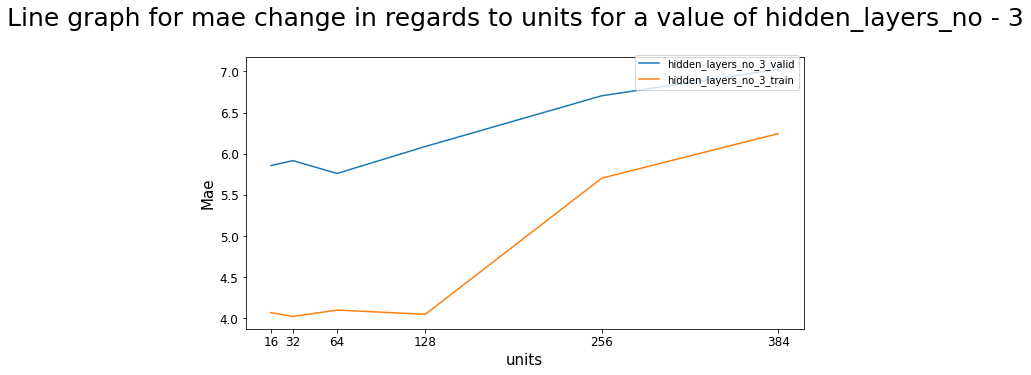

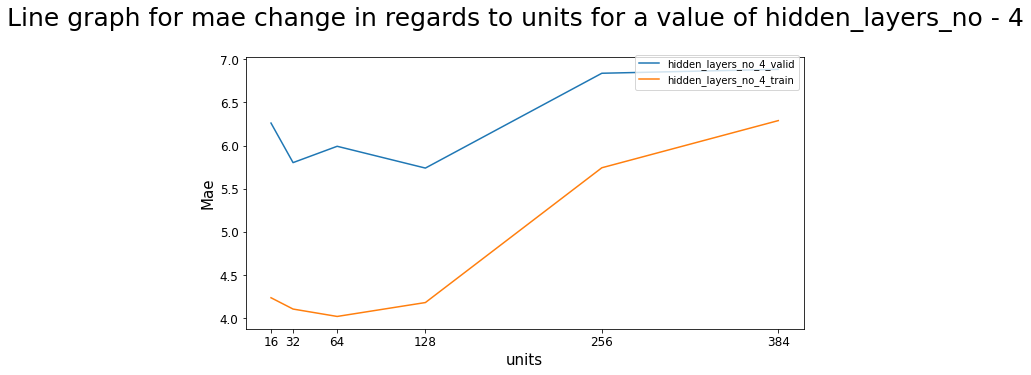

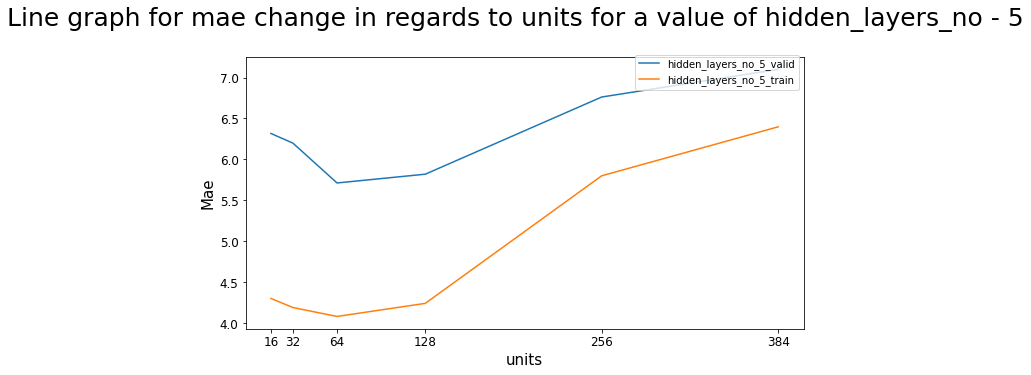

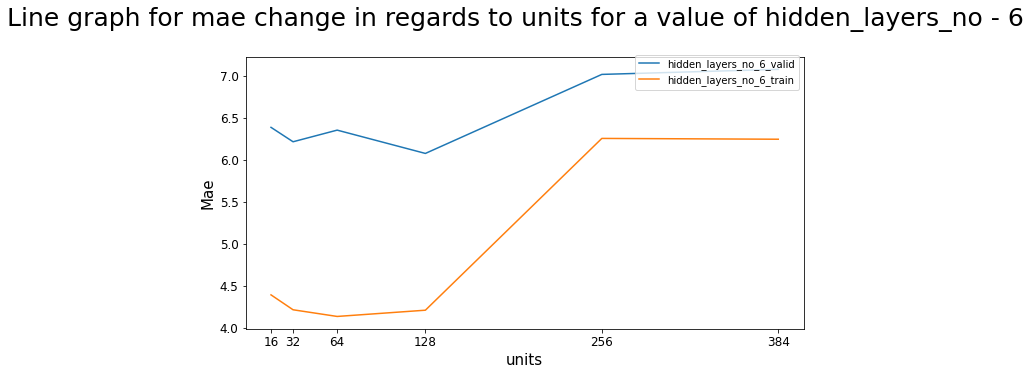

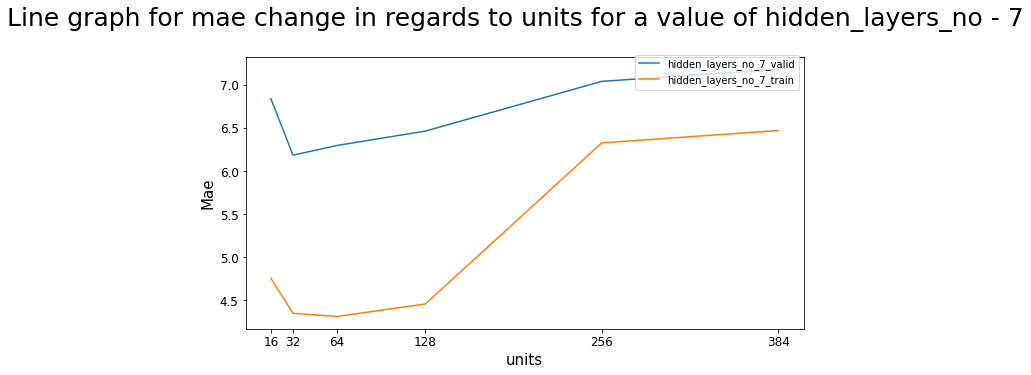

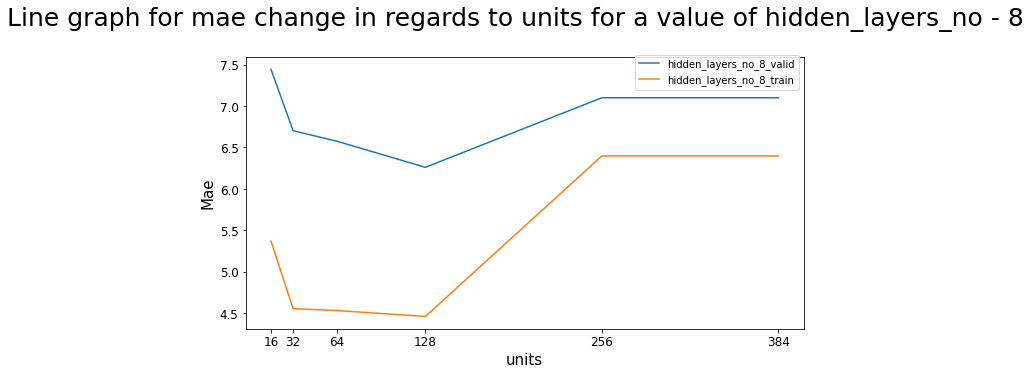

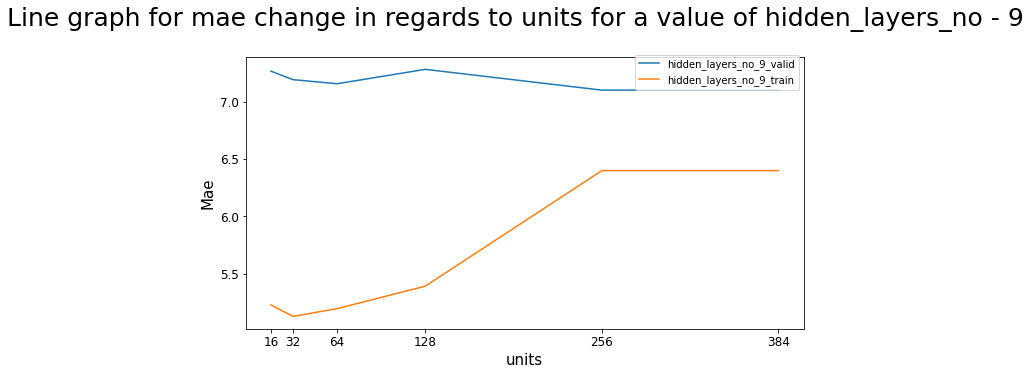

In [142]:
for hid_layers in num_of_hidden_layers:
    plot_line_train_vs_valid(grouped_long_short_term_memory_regression_results_df, group_column_value=hid_layers, acc='mae')

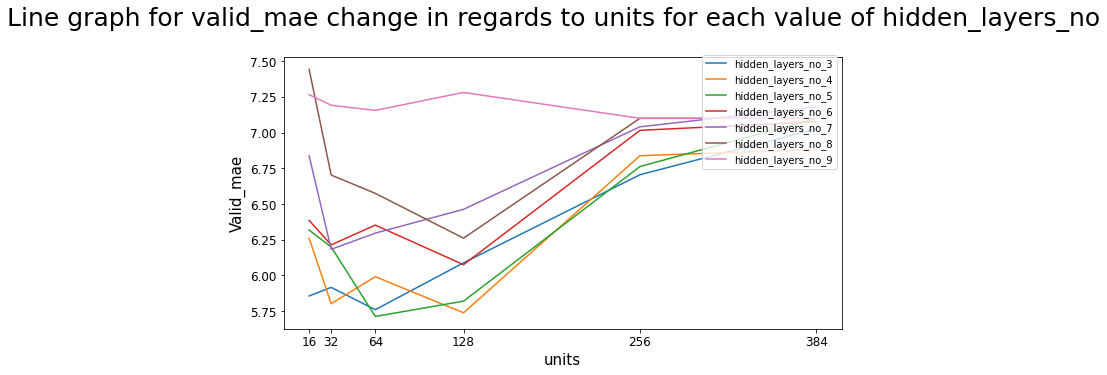

In [140]:
plot_line(grouped_long_short_term_memory_regression_results_df, acc='valid_mae')

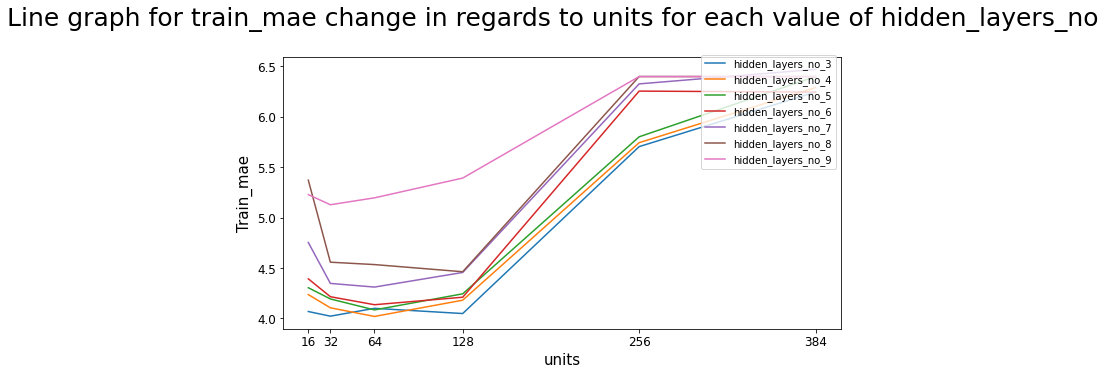

In [121]:
plot_line(grouped_long_short_term_memory_regression_results_df, acc='train_mae')

From the plots above it can be seen that valid MAE is significantly bigger than training MAE. Also, it can be noted that the models with 32-64 `units` does better than ones with higher number of `units` in the `hidden layers`. Moreover, the higher the amount number of `hidden layers`, the more training data overfitts. This is the results of having not enough training data 

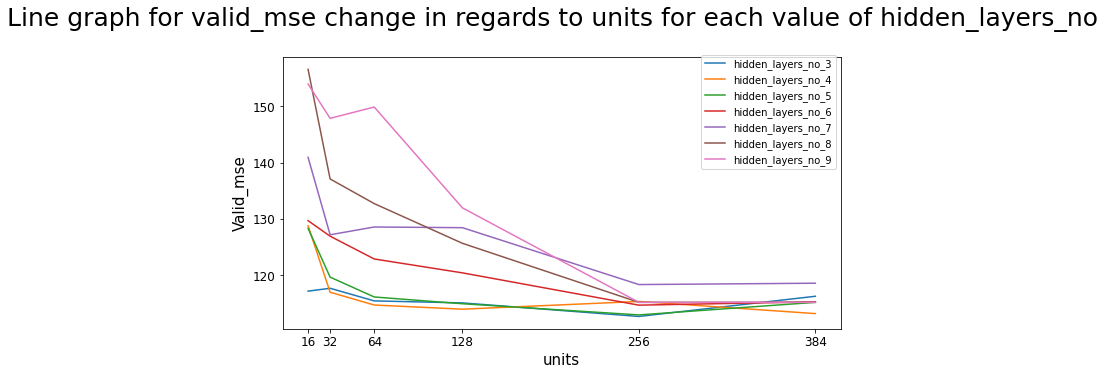

In [144]:
plot_line(grouped_long_short_term_memory_regression_results_df, acc='valid_mse')

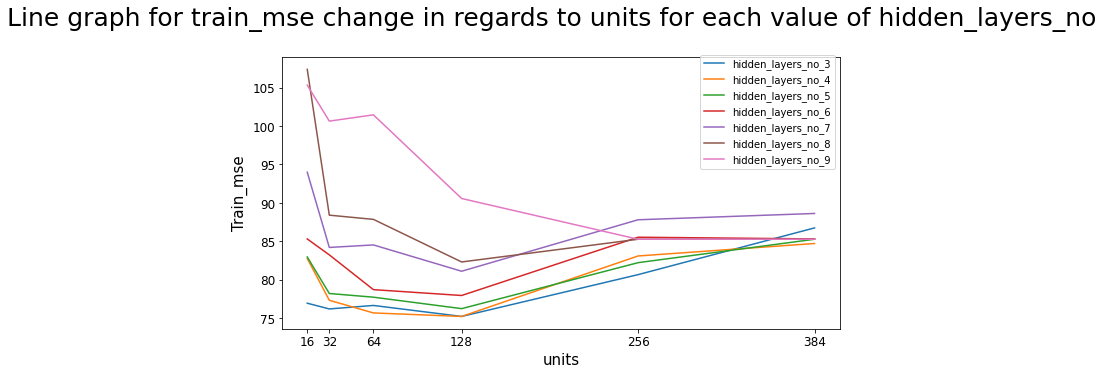

In [145]:
plot_line(grouped_long_short_term_memory_regression_results_df, acc='train_mse')

Simmilarly to MAE scores, MSE is also better on the trainig data.

In [146]:
grouped_long_short_term_memory_regression_results_df[grouped_long_short_term_memory_regression_results_df['valid_rmse'] == grouped_long_short_term_memory_regression_results_df['valid_rmse'].min()]

,optimizer,hidden_layers_no,units,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse,train_mae,train_mse,train_rmse
4,adam,3,256,72.41761,75.340935,-0.081541,-0.041583,6.7047,112.67079,10.500757,5.703001,80.673287,8.86887


In [147]:
grouped_long_short_term_memory_regression_results_df[grouped_long_short_term_memory_regression_results_df['valid_mse'] == grouped_long_short_term_memory_regression_results_df['valid_mse'].min()]

,optimizer,hidden_layers_no,units,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse,train_mae,train_mse,train_rmse
4,adam,3,256,72.41761,75.340935,-0.081541,-0.041583,6.7047,112.67079,10.500757,5.703001,80.673287,8.86887


In [148]:
grouped_long_short_term_memory_regression_results_df[grouped_long_short_term_memory_regression_results_df['valid_mae'] == grouped_long_short_term_memory_regression_results_df['valid_mae'].min()]

,optimizer,hidden_layers_no,units,valid_mean_value,predicted_mean_value,percentage_difference,valid_rsq,valid_mae,valid_mse,valid_rmse,train_mae,train_mse,train_rmse
14,adam,5,64,72.41761,77.269852,-0.107262,-0.071405,5.712753,116.129351,10.626645,4.083405,77.740256,8.752621


The best model is going to be using the hyperparameters that produce the best MAE.

In [56]:
# Encode the data
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train.loc[:, categorical] = enc.fit_transform(X_train[categorical])
X_test.loc[:, categorical] = enc.transform(X_test[categorical])
y_train = y_train.values
y_test = y_test.values

# Scale the data        
scaler_x = preprocessing.StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = preprocessing.StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

# Reshape the data
X_train_transformed = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_transformed = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [57]:
input_shape = (X_train_transformed.shape[1], X_train_transformed.shape[2])

In [58]:
input_shape

(1, 26)

In [59]:
model = build_model_LSTM(input_shape, hid_layer_nums = 5, units=64)
model.compile(optimizer=optimizers['adam'], 
              loss=keras.losses.MeanAbsoluteError(), 
              metrics=["mse", "mae"])

In [60]:
# train the model
history = model.fit(X_train_transformed, y_train_transformed, epochs=40, batch_size=16, verbose=1,
                    validation_data=(X_test_transformed, y_test_transformed)) 

Epoch 1/40
60/60 [==============================] - 11s 37ms/step - loss: 1.2503 - mse: 1.1525 - mae: 0.6921 - val_loss: 1.2695 - val_mse: 0.9019 - val_mae: 0.6285
Epoch 2/40
60/60 [==============================] - 1s 9ms/step - loss: 1.2404 - mse: 0.9987 - mae: 0.5972 - val_loss: 1.2674 - val_mse: 0.9395 - val_mae: 0.6489
Epoch 3/40
60/60 [==============================] - 1s 9ms/step - loss: 1.1211 - mse: 0.9242 - mae: 0.5482 - val_loss: 1.1726 - val_mse: 0.9371 - val_mae: 0.6488
Epoch 4/40
60/60 [==============================] - 1s 9ms/step - loss: 1.0028 - mse: 0.9115 - mae: 0.5304 - val_loss: 1.0401 - val_mse: 0.8693 - val_mae: 0.6137
Epoch 5/40
60/60 [==============================] - 1s 9ms/step - loss: 0.9085 - mse: 0.9087 - mae: 0.5160 - val_loss: 0.9379 - val_mse: 0.8166 - val_mae: 0.5762
Epoch 6/40
60/60 [==============================] - 1s 10ms/step - loss: 0.8615 - mse: 0.9193 - mae: 0.5246 - val_loss: 0.8577 - val_mse: 0.7642 - val_mae: 0.5413
Epoch 7/40
60/60 [=======

In [61]:
hist_dict = history.history = history.history

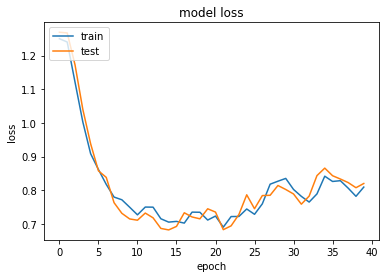

In [62]:
plot_history(hist_dict, metric='loss')

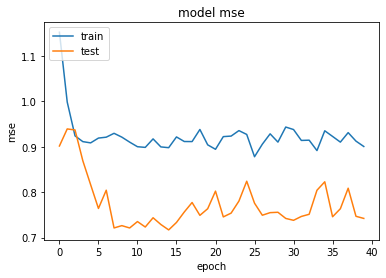

In [63]:
plot_history(hist_dict, metric='mse')

Althought the model overfit when cross-validating, it seems that it did not overfit now.

In [64]:
train_predictions = model.predict(X_train_transformed)
train_predictions = scaler_y.inverse_transform(train_predictions)

test_predictions = model.predict(X_test_transformed)
test_predictions = scaler_y.inverse_transform(test_predictions)
# Obtain metric scores
test_mae = mean_absolute_error(y_test, test_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
test_rsq = r2_score(y_test, test_predictions)
test_mean_value = y_test.mean()
predicted_mean_value = test_predictions.mean()

percetange_difference = ((y_test - test_predictions)/(y_test)).mean()

### Results on test set

In [65]:
print(f"The MAE score on the test set for the best model is {test_mae.round(3)} \n")

The MAE score on the test set for the best model is 5.004 



In [66]:
print(f"The MSE score on the test set for the best model is {test_mse.round(3)} \n")

The MSE score on the test set for the best model is 73.786 



In [67]:
print(f"The RMSE score on the test set for the best model is {test_rmse.round(3)} \n")

The RMSE score on the test set for the best model is 8.59 



In [68]:
print(f"The Rsq score on the test set for the best model is {test_rsq.round(3)} \n")

The Rsq score on the test set for the best model is 0.075 



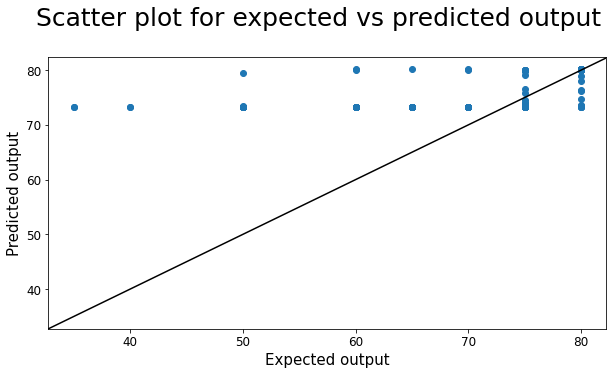

In [38]:
plot_difference(y_test, test_predictions)

Save the model on disc

Save the model on disc

In [46]:
models_dir

'./models/'

In [47]:
model_name

'long_short_term_memory_regression'

In [48]:
model.save_weights(models_dir+model_name+'.h5')

Load the model from disk

In [50]:
model = build_model_LSTM(hid_layer_nums = 5, units=64, input_shape=input_shape)
model.load_weights(models_dir+model_name+'.h5')

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 64)             23296     
                                                                 
 activation_18 (Activation)  (None, 1, 64)             0         
                                                                 
 batch_normalization_18 (Bat  (None, 1, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 64)             33024     
                                                                 
 activation_19 (Activation)  (None, 1, 64)             0         
                                                      